In [1]:
from data.parser import Parser
from data.dataset import Dataset
from model.model import UNet3D, save_model
from model.training import TrainerTester
from os import system

In [2]:
samples = [8, 16, 32, 64, 128, 256, 384, 512, 640, 768, 896, 1024]

In [3]:
# Intialize the parser from the string command
parser = Parser(args=args)
print("Arguments of parser are: ", parser.get_args())
print("Parser is: ", parser.get_parser())
print("Number of samples: ", parser.get_n_samples())
print("Number of epochs: ", parser.get_n_epochs())
print("Stress number: ", parser.get_stress_number())
print("Retrain: ", parser.get_retrain())
print("Model name: ", parser.get_model_name())
print("Data path: ", parser.get_data_path())

Arguments of parser are:  {'n_samples': 64, 'n_epochs': 1000, 'stress_number': 0, 'retrain': False, 'model_name': None, 'data_path': 'data/data_files/'}
Parser is:  ArgumentParser(prog='ipykernel_launcher.py', usage=None, description='Parser for the simulation parameters', formatter_class=<class 'argparse.HelpFormatter'>, conflict_handler='error', add_help=True)
Number of samples:  64
Number of epochs:  1000
Stress number:  0
Retrain:  False
Model name:  None
Data path:  data/data_files/


In [4]:
dataset = Dataset(parser.get_data_path(), n_samples=parser.get_n_samples(), augment=1)
print("Data path of dataset is: ", dataset.data_path)
print("Device of dataset is: ", dataset.device)
print("Number of samples of dataset is: ", dataset.n_samples)
print("Stress number of dataset is: ", dataset.stress_number)
print("Load number of dataset is: ", dataset.load_number)
print("Maxfile of dataset is: ", dataset._maxfile)

Device:  cpu
<class 'int'>
64
<class 'torch.device'>
cpu
Preprocessing of file 1 out of 1
Value of n:  64 Value of i:  0
File 1 loaded
Input of file 1 saved. It corresponds to the young modulus.
Output of file 1 saved.                        It corresponds to the stress number 0 and the load number 0
Data path of dataset is:  data/data_files/
Device of dataset is:  cpu
Number of samples of dataset is:  64
Stress number of dataset is:  0
Load number of dataset is:  0
Maxfile of dataset is:  1


In [5]:
dataset.preprocessing()
print("Preprocessing of dataset is done.")
dataset.augmentate()
print("Augment of dataset is done.")
dataset.load_data()
print("Data of dataset is loaded.")

print("Length of dataset is: ", len(dataset))
print("Item 0 of dataset is: ", dataset[0])

Preprocessing of file 1 out of 1
Data already preprocessed
Preprocessing of dataset is done.
Input size:  torch.Size([384, 1, 64, 64, 64])
Output size:  torch.Size([384, 1, 64, 64, 64])
Augment of dataset is done.
Input size:  torch.Size([384, 1, 64, 64, 64])
Output size:  torch.Size([384, 1, 64, 64, 64])
Data of dataset is loaded.
Length of dataset is:  64
Item 0 of dataset is:  (tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1.,

Trainer initialized
Epoch 1/1 - Training Loss: 0.1119 - Testing Loss: 1.0383
Computing the lowest loss
Lowest loss at index 6
1.228013515472412


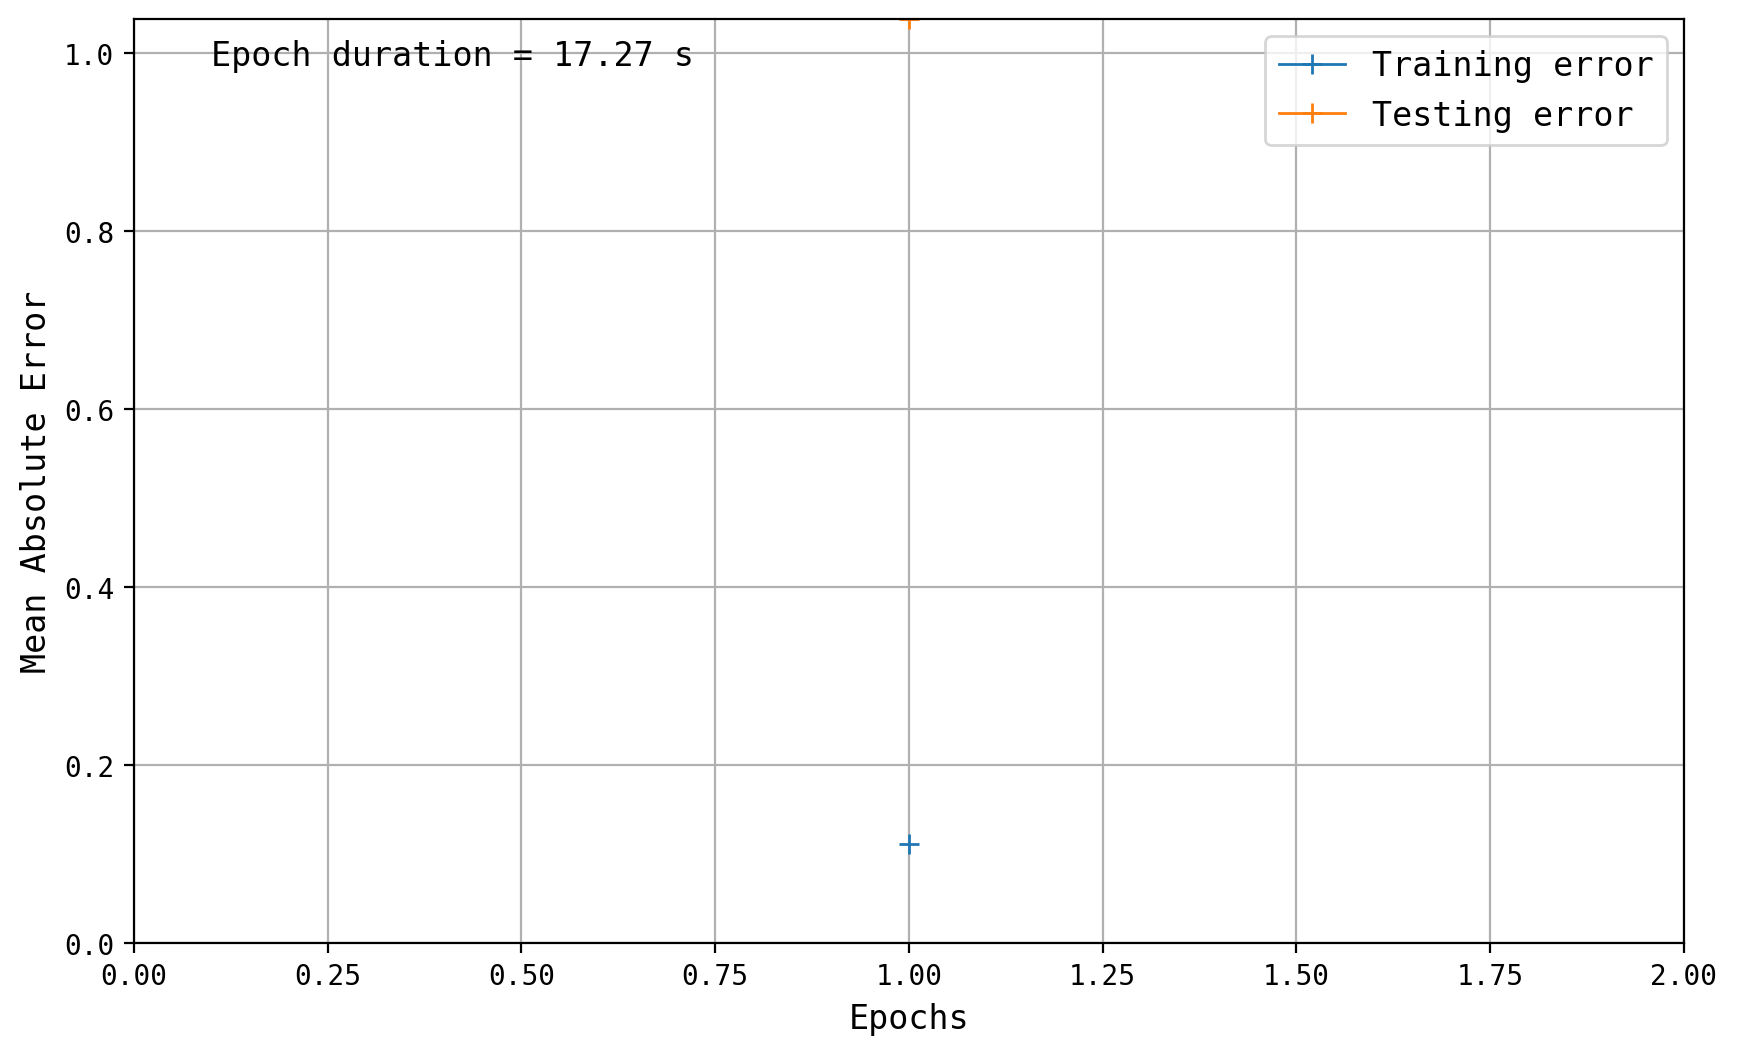

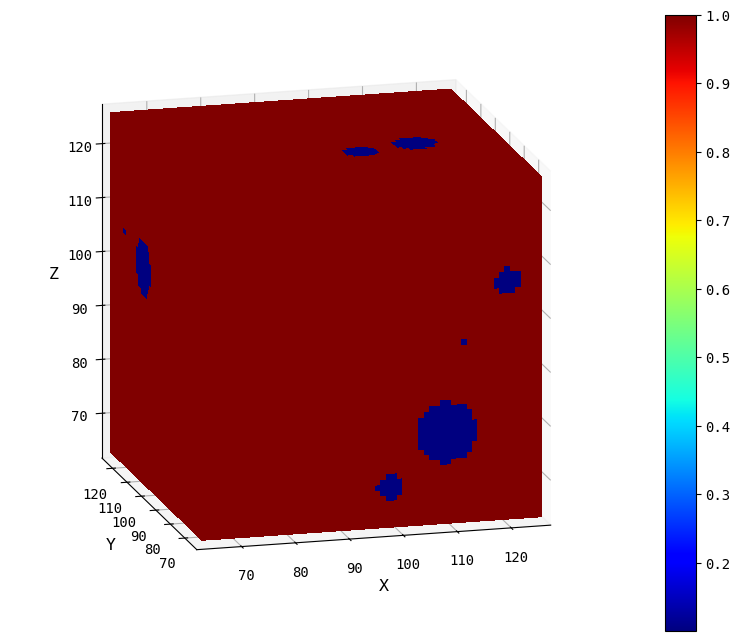

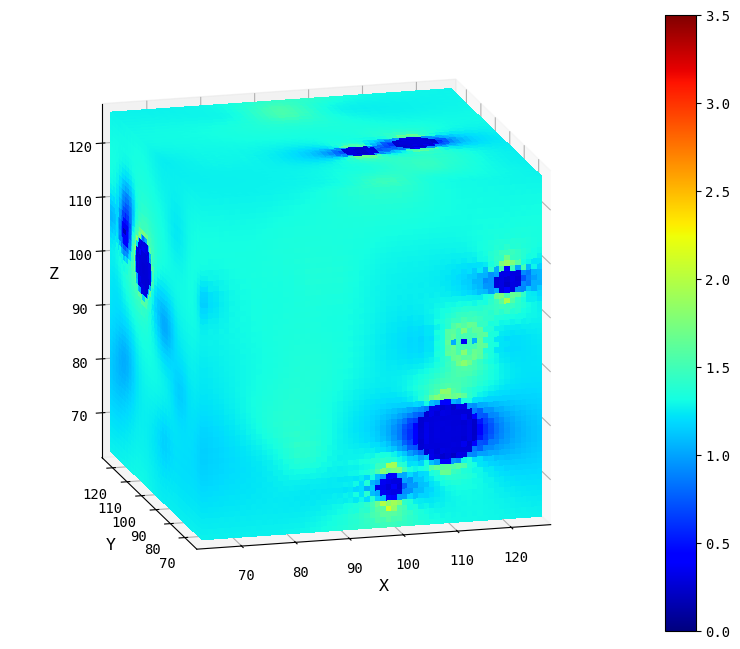

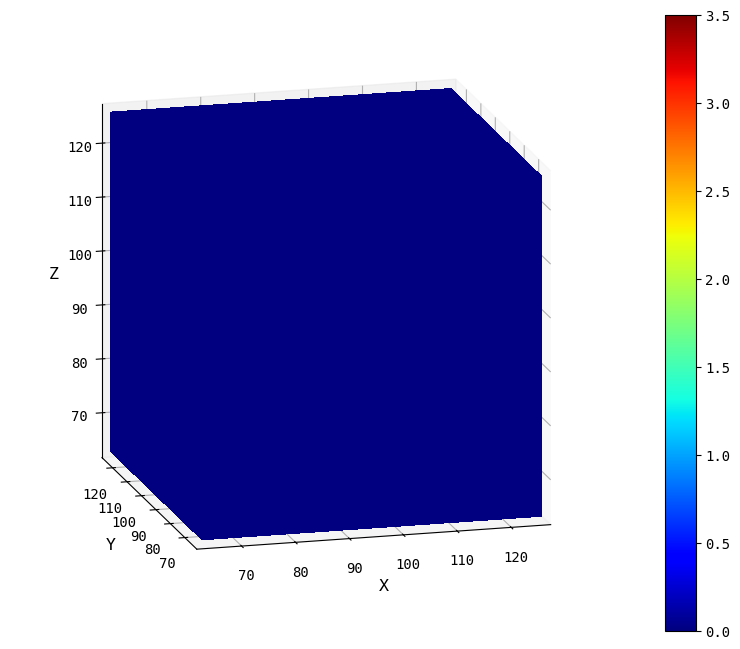

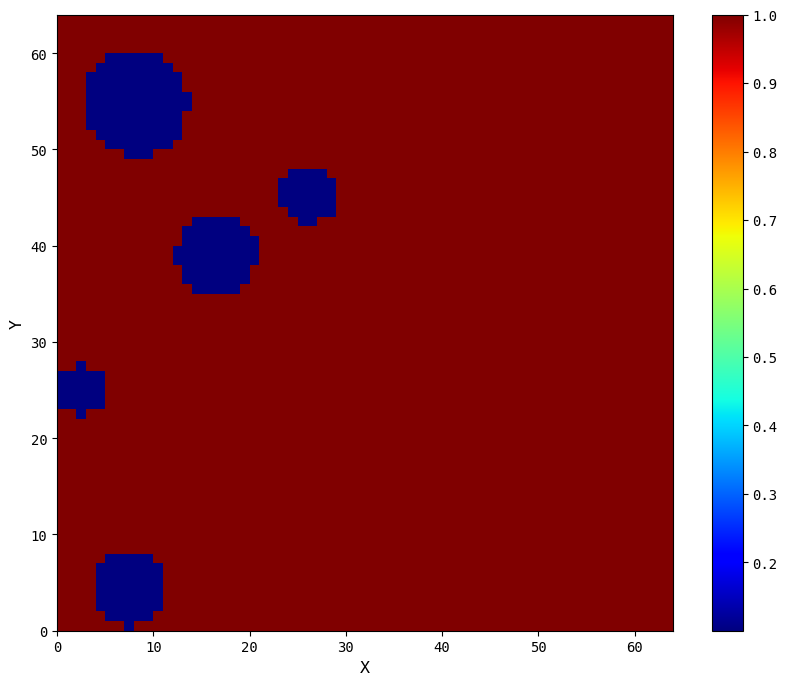

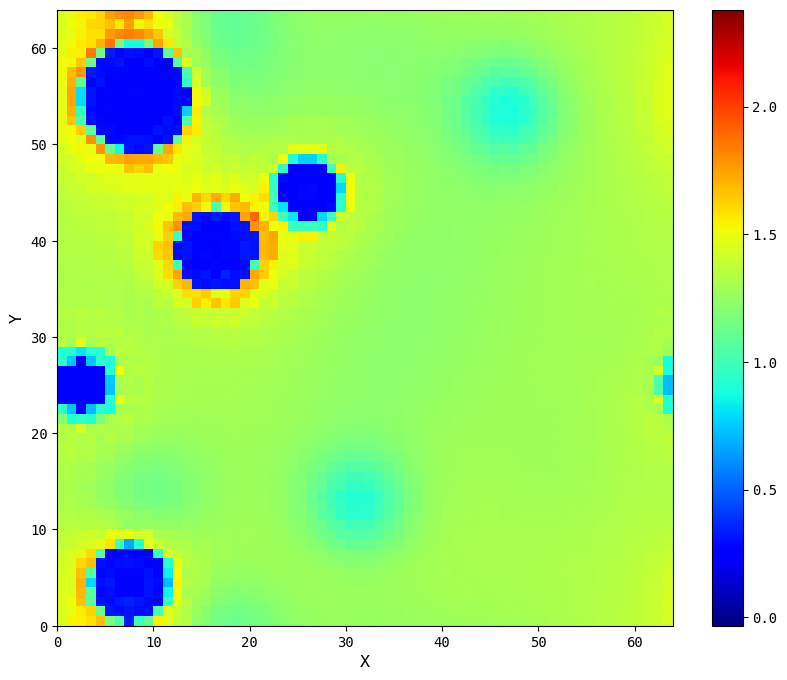

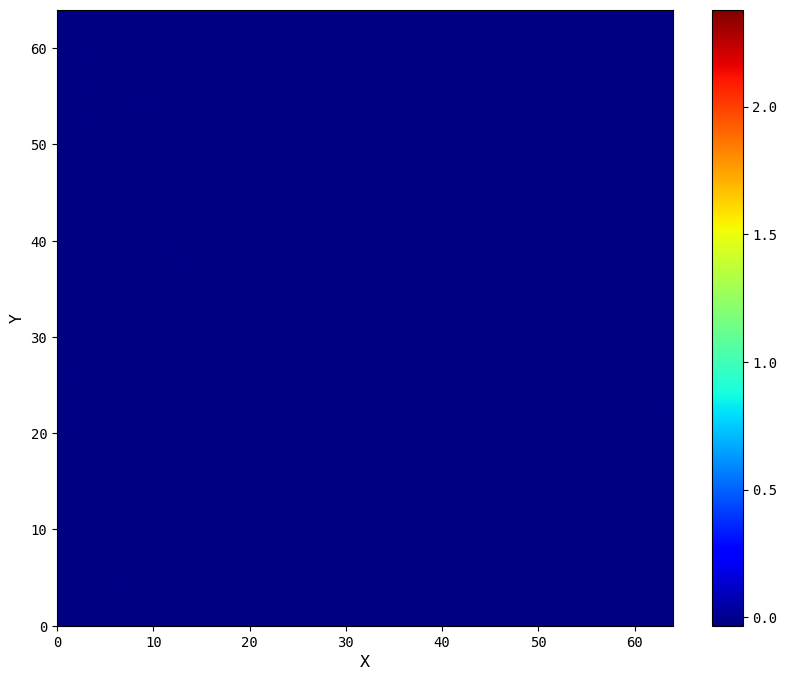

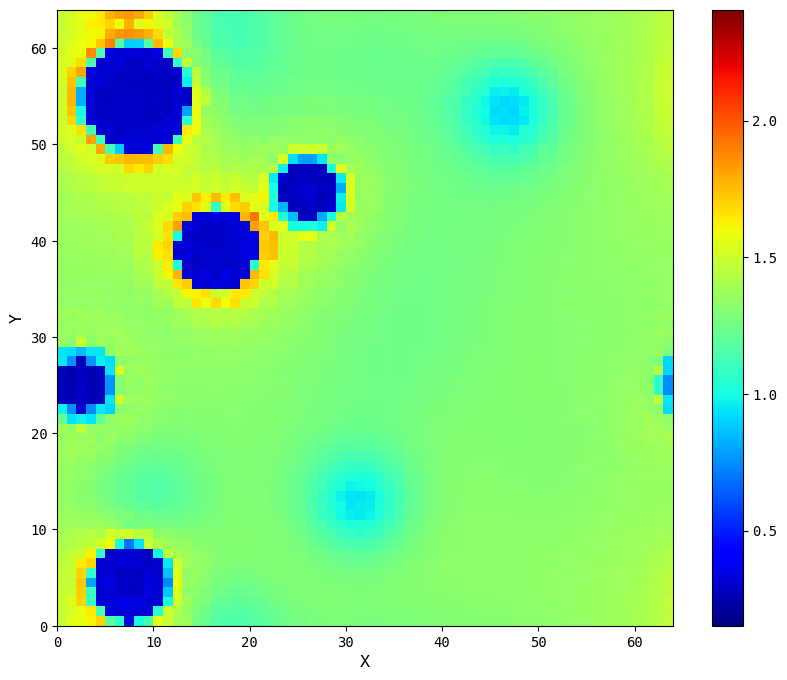

In [6]:
model = UNet3D()

trainer = TrainerTester(model, dataset)
print("Trainer initialized")
trainer.train(n_epochs=1)

In [7]:
dataset.__del__()

In [8]:
# training = TrainerTester(model, dataset)
# print("Model of training is: ", training.model)

# training.train(n_epochs=2) # Train the model

In [9]:
# # save the model
# save_key = f"N{dataset.n_samples}_stress{dataset.stress_number}_loading{dataset.load_number}"
# save_model(model, save_key=save_key, epochs=training.epochs)